<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula03c_Hinge_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)
  plt.xlim(0, 1)
  plt.ylim(0, 1)


In [194]:
def plotHiperplano(vector, intercept=0, dataset=None):
  xs = np.array([0, 1])
  ys = -(vector[0]*xs+intercept)/vector[1]
  plt.plot(xs, ys, 'r-')


In [195]:
import numpy as np

def criaDataset(n=20, slop=[2,1], intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = X * np.array(slop) - [0, intercept]
  y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
  return X, y

X, y = criaDataset()


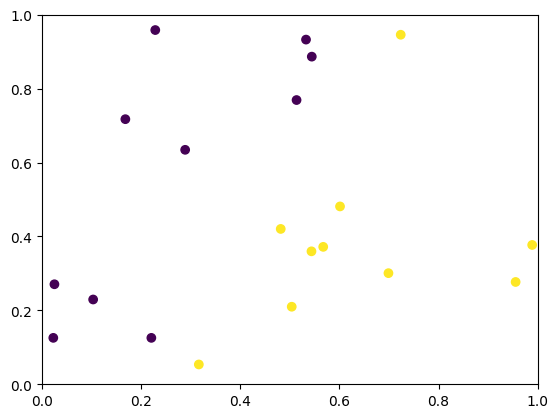

In [196]:
plotDataset(X, y)
plt.show()

In [197]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def sign(a):
  return (a>=0)*2-1


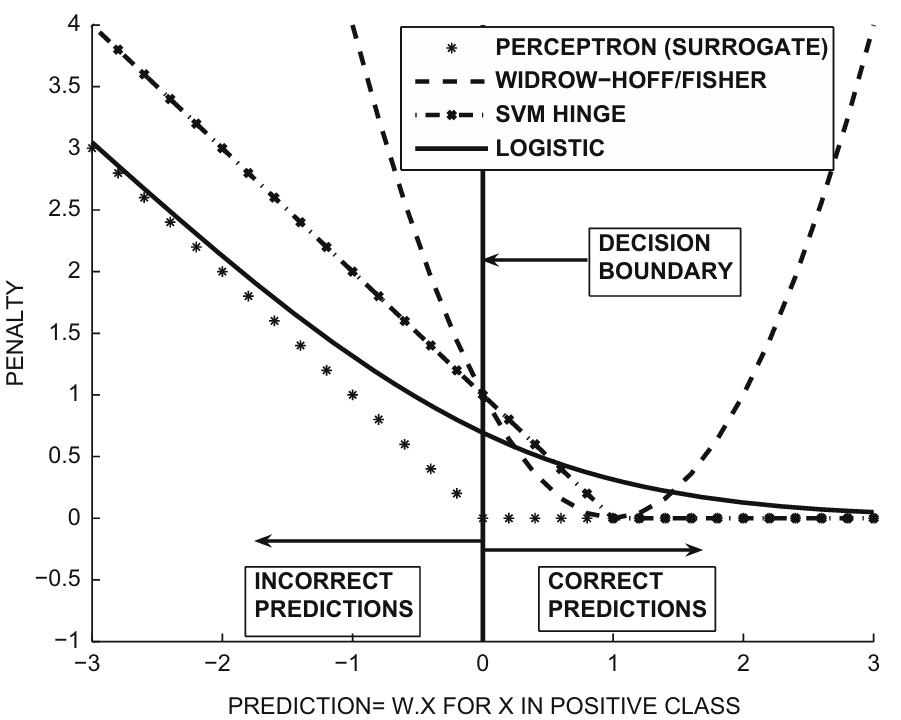

In [198]:
from abc import ABC, abstractstaticmethod

class Cost(ABC):
  @abstractstaticmethod
  def getCost(y, ypred):
    pass
  @abstractstaticmethod
  def getGradient(y, ypred, X):
    pass

class WidrowHoff(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y-ypred)

class SmoothedSurrogate(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y - sign(ypred))

class HingeLoss(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1-y*ypred))
  @staticmethod
  def getGradient(y, ypred, X):
    marginalserrors = (y * ypred) < 1
    marginal_ys = np.copy(y)
    marginal_ys[~marginalserrors] = 0
    return X.T @ marginal_ys

In [199]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y):
    pass

class GradientDescent(TrainingAlgorithm):
  def __init__(self, max_iter=1000, learning_rate=0.01, cost=HingeLoss()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=X.shape[1])
    for _ in range(self.max_iter):
      ypred = X @ w
      error = y - ypred
      w += self.cost.getGradient(y, ypred, X) * self.learning_rate
      if self.cost.getCost(y, ypred) == 0:
        break
    return w


In [200]:
def include_bias(X):
  bias = np.ones((X.shape[0],1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, trainingAlgorithm=GradientDescent()):
    self.trainingAlgorithm = trainingAlgorithm

  def fit(self, X, y):
    Xb = include_bias(X)
    self.w = self.trainingAlgorithm.getW(Xb, y)
    return self

  def predict(self, X):
    Xb = include_bias(X)
    return sign(Xb @ self.w)


[-1.13034726  7.45329975 -4.44128725]
1.0


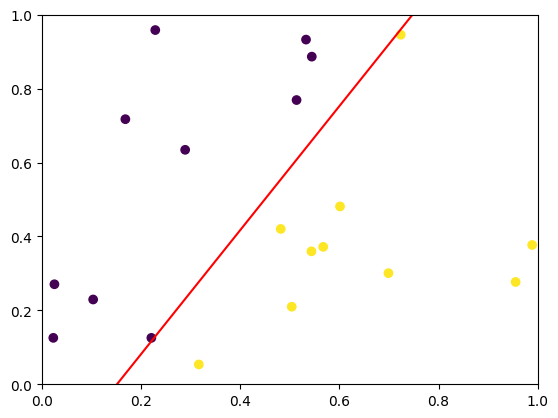

0.982


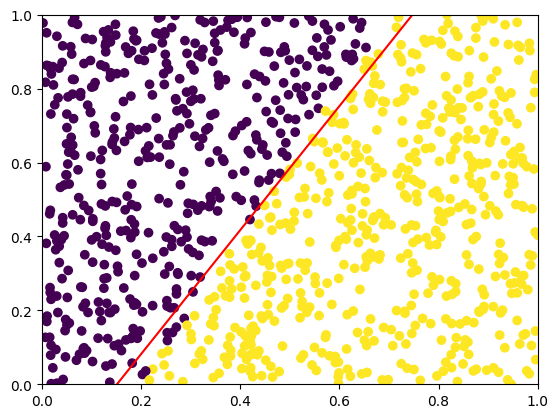

In [201]:
Xtest, ytest = criaDataset(n=1000)
model = NeuralNetwork(trainingAlgorithm=GradientDescent(cost=HingeLoss()))
model.fit(X, y)
ypred = model.predict(X)
print(model.w)
print(accuracy_score(y, ypred))
plotDataset(X, y)
plotHiperplano(vector=model.w[1:], intercept=model.w[0])
plt.show()
ypred = model.predict(Xtest)
print(accuracy_score(ytest, ypred))
plotDataset(Xtest, ytest)
plotHiperplano(vector=model.w[1:], intercept=model.w[0])
plt.show()